<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook/Lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Implementation of LeNet5

- PyTorch를 이용하여 LeNet5 architecture를 구현하고, cifar-10 dataset을 이용해 모델을 훈련해봅니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

- print(device)를 통해 cuda가 출력되어 GPU를 활용할 수 있음을 확인합니다.

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path2 = '/content/drive/My Drive/Class/2020-2-bme-dip/data03/'

- torchvision를 통해 여러 유명한 dataset을 서버로부터 다운로드할 수 있습니다.cifar10을 download하고, 미리 알고 있는 label정보로 함수를 정의합니다.
- DataLoader함수를 이용하여 batch_size만큼씩 데이터를 가져올 수 있도록 iteration함수를 정의합니다.

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor()])

cifar10_train = torchvision.datasets.CIFAR10(path2, train=True, transform=transform, target_transform=None, download=True)
cifar10_valid = torchvision.datasets.CIFAR10(path2, train=False, transform=transform, target_transform=None, download=True)
def get_cifar10_labels(labels):
    text_labels = ['airplane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    return [text_labels[int(i)] for i in labels]

# defining data_iter, linreg. model, loss, sgd
batch_size = 100
num_workers = 0
train_iter = DataLoader(cifar10_train, batch_size, shuffle=True, num_workers=num_workers)
valid_iter = DataLoader(cifar10_valid, batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


- cifar10 데이터에 대해 살펴봅니다.

In [6]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/My Drive/Class/2020-2-bme-dip/data03/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
cifar10_valid

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/My Drive/Class/2020-2-bme-dip/data03/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

torch.Size([100])
torch.Size([100, 3, 32, 32])


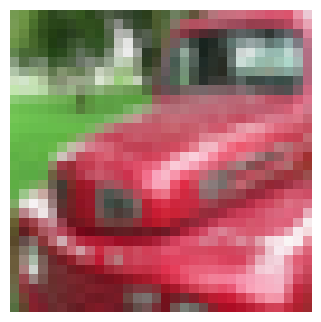

['car']


In [8]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0].numpy()
plt.figure(dpi=100)

plt.imshow(np.transpose(I,[1,2,0]),cmap='gray')
plt.axis('off')
plt.show()
print(get_cifar10_labels([labels[0]]))

- CNN architecture를 정의합니다.
- 아래는 LeNet을 구현한 예입니다.

In [9]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*6*6, out_features=120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=576, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

- 임의로 random tensor를 생성하여, network의 각 layer에 shape을 확인해봅니다.

In [10]:
X = torch.randn(size=(1,3,32,32), dtype = torch.float32)
X = X.to(device)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 32, 32])
Sigmoid output shape: 	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape: 	 torch.Size([1, 6, 16, 16])
Conv2d output shape: 	 torch.Size([1, 16, 12, 12])
Sigmoid output shape: 	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape: 	 torch.Size([1, 16, 6, 6])
Flatten output shape: 	 torch.Size([1, 576])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


- Learning rate, num_epochs, loss function, backpropagation algorithm을 정해줍니다..

In [11]:
# setting hyper-parameters
learning_rate = 0.9
num_epochs = 100

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

- 네트워크에 대한 훈련을 진행합니다. 매 10회마다 결과를 출력하게 하였습니다. train, valid accuracy의 변화를 관찰합니다.
- 최종결과가 만족스럽지 않은 경우에는 hyper-parameter를 바꾸어가며 다시 학습을 진행합니다.
- input data에 대한 random transformation을 추가하는 것은 overfitting에 도움을 줄 수 있습니다.
- vggnet이나 resnet과 같이 좀 더 효율적인 네트워크 구조를 적용해 볼 수도 있습니다.

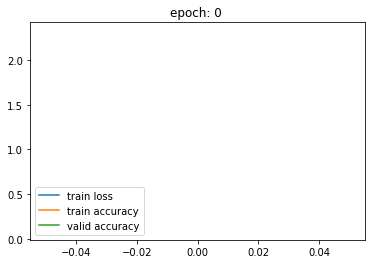

train loss:  2.31191650390625
train accuracy:  0.10016000270843506
valid accuracy:  0.10000000149011612


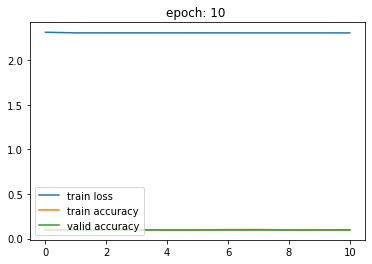

train loss:  2.30452197265625
train accuracy:  0.10012000054121017
valid accuracy:  0.10000000149011612


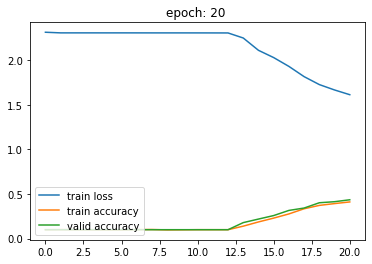

train loss:  1.612271728515625
train accuracy:  0.4109799861907959
valid accuracy:  0.43529999256134033


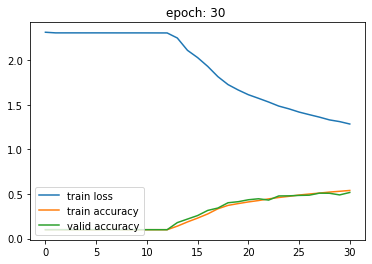

train loss:  1.2839833984375
train accuracy:  0.5394999980926514
valid accuracy:  0.5170999765396118


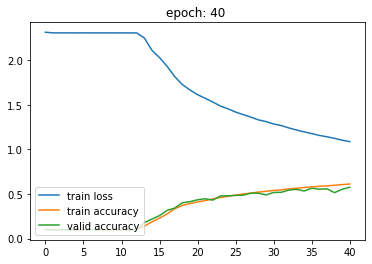

train loss:  1.086253173828125
train accuracy:  0.6116399765014648
valid accuracy:  0.5758000016212463


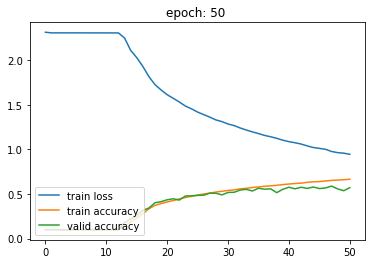

train loss:  0.9445908203125
train accuracy:  0.6657800078392029
valid accuracy:  0.5708000063896179


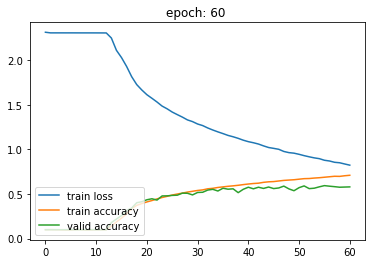

train loss:  0.822896728515625
train accuracy:  0.7096199989318848
valid accuracy:  0.5795000195503235


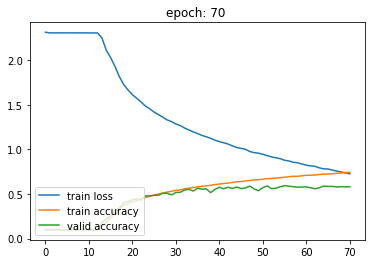

train loss:  0.7258264770507813
train accuracy:  0.7422199845314026
valid accuracy:  0.5803999900817871


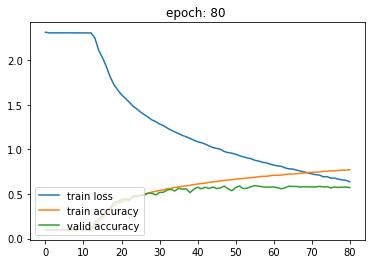

train loss:  0.6367974243164063
train accuracy:  0.7723399996757507
valid accuracy:  0.5720999836921692


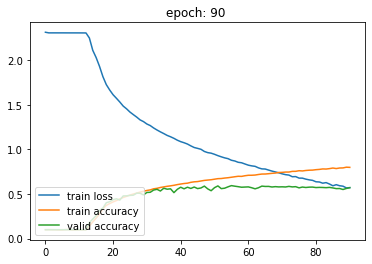

train loss:  0.5712051391601562
train accuracy:  0.79830002784729
valid accuracy:  0.5706999897956848


In [12]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device) # GPU 
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/50000.)

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()

  accs_valid = np.append(accs_valid,correct.cpu()/10000.)


  if epoch%10 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

In [23]:
print('valid_accuracy: ',accs_valid[-1])


valid_accuracy:  0.5593000054359436


- validation set의 몇몇 example에 대한 결과를 관찰해 봅니다.

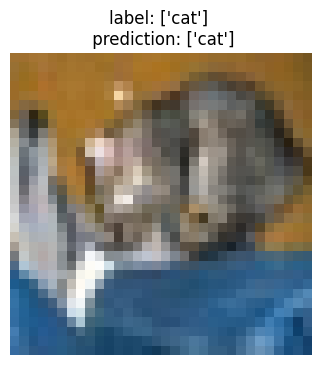

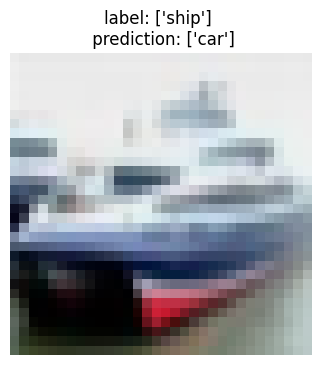

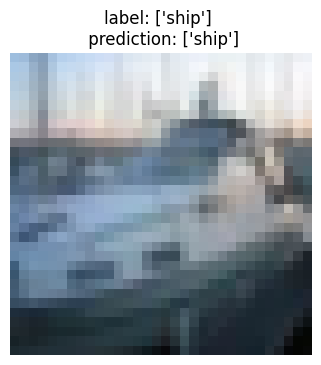

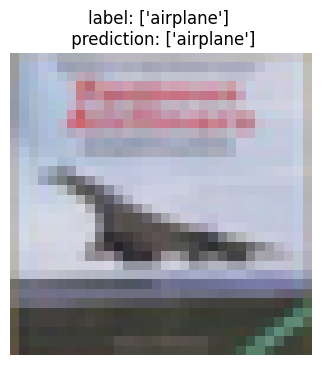

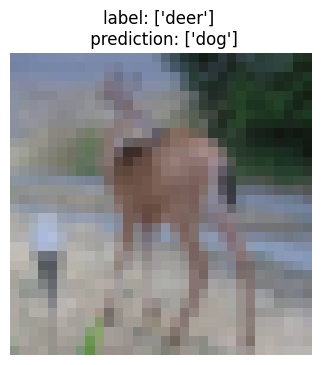

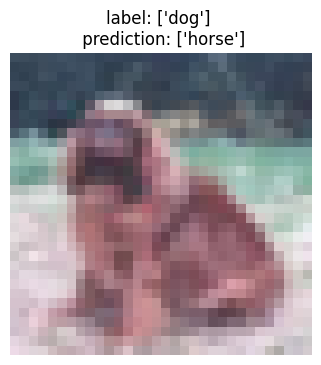

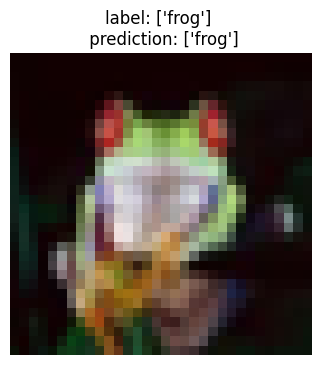

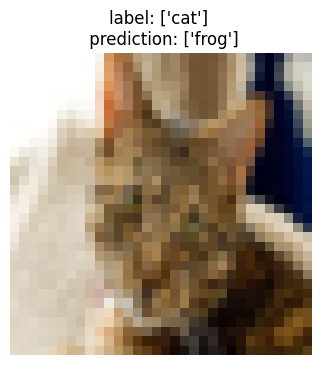

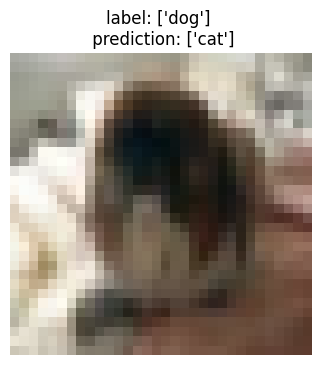

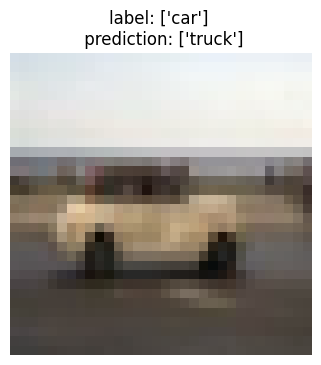

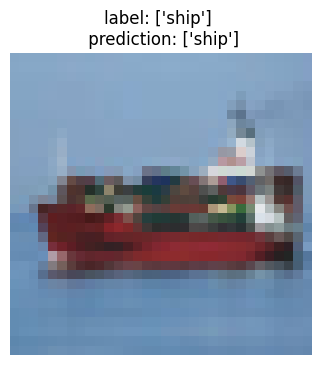

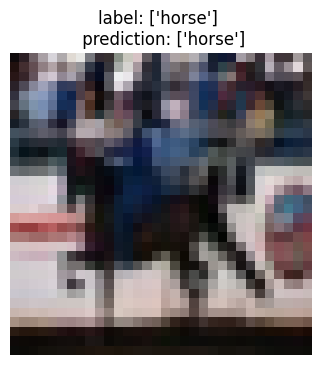

In [13]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(4):
    plt.figure(dpi=100)
    plt.imshow(np.transpose(X[n].cpu().squeeze(),[1,2,0]),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(get_cifar10_labels([y[n]]),get_cifar10_labels([y_hat[n]])))
    plt.axis('off')
    plt.pause(.0001)
  if i>2:
     break